# 取り組み

+ [ ] right_loxpがいまいちな理由を考察する
left_loxpに比べてright_loxpのクラスタがはっきりしない

### 補正がうまく行っていないことがわかった

- `chr2:180,264,007（329）`の欠失はbartcode31にも42にも同程度で見られる
    - にもかかわらず補正がされていない
    - ClusteringではなくPreprocessingにおける補正の問題である
- `chr2:180,263,057（1279）`の挿入も同様にbartcode31にも42にも同程度で見られる

補正がうまく行っていないために、right_loxpのクラスタリングがうまく行っていないと考えられる
-> `preprocessing`にてデバッグする


In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


# 実験

In [2]:
from __future__ import annotations

import sys, os
from pathlib import Path

sys.path.append("/mnt/d/Research/DAJIN2")
os.chdir("/mnt/d/Research/DAJIN2")

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

# # * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "test-ayabe-task1",
    "mm10",
    True,
    14,
)

print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

processing test-ayabe-task1...


In [3]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from copy import deepcopy
from pathlib import Path
import midsv
from scipy import stats
from scipy.spatial.distance import cosine


def set_indexes(sequence: str):
    sequence_length = len(sequence)
    num_subset = sequence_length % 5
    left_idx = 0
    right_idx = sequence_length
    if num_subset == 1:
        left_idx += 1
    elif num_subset == 2:
        left_idx += 1
        right_idx -= 1
    elif num_subset == 3:
        left_idx += 2
        right_idx -= 1
    elif num_subset == 4:
        left_idx += 2
        right_idx -= 2
    return left_idx, right_idx


def count_indels_5mer(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
    transposed = [list(t) for t in zip(*cssplits)]
    count_indels_5mer = []
    for i in range(left_idx, right_idx, 5):
        count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
        cssplits_5mer = transposed[i : i + 5]
        for j, cs in enumerate(cssplits_5mer):
            counter = Counter(cs)
            for key, cnt in counter.items():
                if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
                    continue
                if key.startswith("+"):
                    count["ins"][j] += cnt
                elif key.startswith("-"):
                    count["del"][j] += cnt
                elif key.startswith("*"):
                    count["sub"][j] += cnt
        count_indels_5mer.append(count)
    return count_indels_5mer


def extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    for i in range(len(sequence_errors)):
        for mutation in ["ins", "del", "sub"]:
            samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
            cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
            distance = 1 - cosine(samp, cont)
            _, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
            if distance > 0.95 and pvalue > 0.05:
                sequence_errors[i].add(mutation)
    return sequence_errors


def replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
    cssplits_replaced = []
    for samp in cssplits_sample:
        samp_replaced = deepcopy(samp)
        for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
            samp_5mer = samp[idx_5mer : idx_5mer + 5]
            error = sequence_errors[idx_error]
            if "ins" in error:
                samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
            if "del" in error:
                samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
            if "sub" in error:
                samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
            samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
        cssplits_replaced.append(samp_replaced)
    return cssplits_replaced


def replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = deepcopy(cssplits)
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "=" + sequence[0]
        if cs[-1] == "@":
            cs[-1] = "=" + sequence[-1]
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        coverage_sample = len(midsv_sample)
        coverage_control = len(midsv_control)
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        left_idx, right_idx = set_indexes(sequence)
        count_5mer_sample = count_indels_5mer(cssplits_sample, left_idx, right_idx)
        count_5mer_control = count_indels_5mer(cssplits_control, left_idx, right_idx)
        sequence_errors = extract_sequence_errors(
            count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
        )
        cssplits_sample_error_replaced = replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
        cssplits_control_error_replaced = replace_errors_to_atmark(
            cssplits_control, sequence_errors, left_idx, right_idx
        )
        cssplits_sample_atmark_replaced = replace_atmark(cssplits_sample_error_replaced, sequence)
        cssplits_control_atmark_replaced = replace_atmark(cssplits_control_error_replaced, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))



In [5]:
allele = "control"
sv = False
sequence = FASTA_ALLELES[allele]

In [6]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
coverage_sample = len(midsv_sample)
coverage_control = len(midsv_control)
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

In [7]:
i_del = 329
i_ins = 1280

In [10]:
from collections import defaultdict
from collections import Counter

count = defaultdict(int)
for cs in cssplits_control:
    count[cs[i_del]] += 1
print("=====================")
print(f"control @ {i_del}")
print(count)

count = defaultdict(int)
for cs in cssplits_sample:
    count[cs[i_del]] += 1
print("=====================")
print(f"sample @ {i_del}")
print(count)

control @ 329
defaultdict(<class 'int'>, {'=C': 824, '-C': 125, 'N': 8, '+A|*CA': 3, '+C|=C': 3, '+C|+C|=C': 4, '+G|*CT': 1})
sample @ 329
defaultdict(<class 'int'>, {'=C': 831, '+C|=C': 9, '-C': 129, 'N': 10})


In [11]:
from collections import defaultdict
from collections import Counter

count = defaultdict(int)
for cs in cssplits_control:
    count[cs[i_ins]] += 1
print("=====================")
print(f"control @ {i_ins}")
print(count)

count = defaultdict(int)
for cs in cssplits_sample:
    count[cs[i_ins]] += 1
print("=====================")
print(f"sample @ {i_ins}")
print(count)

control @ 1280
defaultdict(<class 'int'>, {'=G': 850, '+A|=G': 26, '-G': 25, '+G|=G': 2, 'N': 34, '+A|+G|=G': 19, '+A|+A|=G': 1, '+G|+A|+G|=G': 1, '+G|+A|=G': 2, '+G|+T|=G': 2, '+G|+A|+A|+A|+G|=G': 1, '+A|+A|+G|=G': 1, '+C|+G|=G': 2, '+T|=G': 1, '+C|+A|=G': 1})
sample @ 1280
defaultdict(<class 'int'>, {'=G': 819, '+A|=G': 64, '-G': 39, '+A|+G|=G': 16, 'N': 26, '+G|+A|=G': 1, '+T|+A|=G': 1, '+A|+T|+T|+C|+T|=G': 7, '+A|*GC': 1, '+C|+A|=G': 1, '+C|+A|+G|+A|=G': 1, '+A|+G|+A|=G': 1, '+G|=G': 2})


In [12]:
left_idx, right_idx = set_indexes(sequence)
count_5mer_sample = count_indels_5mer(cssplits_sample, left_idx, right_idx)
count_5mer_control = count_indels_5mer(cssplits_control, left_idx, right_idx)
sequence_errors = extract_sequence_errors(
    count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
)

In [17]:
print(i_del//5)
print(count_5mer_sample[i_del//5])
print(count_5mer_control[i_del//5])
print(sequence_errors[i_del//5])

65
{'ins': [2, 5, 10, 5, 2], 'del': [9, 23, 130, 43, 6], 'sub': [1, 1, 1, 1, 1]}
{'ins': [3, 6, 12, 4, 10], 'del': [2, 11, 126, 93, 8], 'sub': [1, 1, 1, 1, 1]}
set()


In [18]:
samp = [c / coverage_sample for c in [9, 23, 130, 43, 6]]
cont = [c / coverage_control for c in [2, 11, 126, 93, 8]]
distance = 1 - cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
print(distance, pvalue)

0.9453921012935363 0.8592465758672474


In [19]:
print(i_ins//5)
print(count_5mer_sample[i_ins//5])
print(count_5mer_control[i_ins//5])
print(sequence_errors[i_ins//5])

256
{'ins': [7, 7, 3, 9, 30], 'del': [1, 1, 1, 1, 1], 'sub': [1, 1, 1, 1, 1]}
{'ins': [19, 15, 18, 23, 35], 'del': [1, 1, 1, 1, 1], 'sub': [1, 1, 1, 1, 1]}
set()


In [20]:
samp = [c / coverage_sample for c in count_5mer_sample[i_ins//5]["ins"]]
cont = [c / coverage_control for c in count_5mer_control[i_ins//5]["ins"]]
distance = 1 - cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
print(distance, pvalue)

0.9098501265616633 0.1041139955936684


### 原因
- 329も1280もdistanceが0.95以下であることによって補正を免れていた。
    - → `extract_sequence_errors`における`distance`の閾値を0.95から0.9に変更した

In [23]:
def extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    for i in range(len(sequence_errors)):
        for mutation in ["ins", "del", "sub"]:
            samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
            cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
            distance = 1 - cosine(samp, cont)
            _, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
            if distance > 0.9 and pvalue > 0.05:
                sequence_errors[i].add(mutation)
    return sequence_errors

In [24]:
sequence_errors = extract_sequence_errors(
    count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
)

In [25]:
print(sequence_errors[i_del//5])

{'del'}


In [26]:
print(sequence_errors[i_ins//5])

{'ins'}


## distance 0.9にすると、knokcinのright-loxpは検出できるのか？

In [27]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from copy import deepcopy
from pathlib import Path
import midsv
from scipy import stats
from scipy.spatial.distance import cosine


def set_indexes(sequence: str):
    sequence_length = len(sequence)
    num_subset = sequence_length % 5
    left_idx = 0
    right_idx = sequence_length
    if num_subset == 1:
        left_idx += 1
    elif num_subset == 2:
        left_idx += 1
        right_idx -= 1
    elif num_subset == 3:
        left_idx += 2
        right_idx -= 1
    elif num_subset == 4:
        left_idx += 2
        right_idx -= 2
    return left_idx, right_idx


def count_indels_5mer(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
    transposed = [list(t) for t in zip(*cssplits)]
    count_indels_5mer = []
    for i in range(left_idx, right_idx, 5):
        count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
        cssplits_5mer = transposed[i : i + 5]
        for j, cs in enumerate(cssplits_5mer):
            counter = Counter(cs)
            for key, cnt in counter.items():
                if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
                    continue
                if key.startswith("+"):
                    count["ins"][j] += cnt
                elif key.startswith("-"):
                    count["del"][j] += cnt
                elif key.startswith("*"):
                    count["sub"][j] += cnt
        count_indels_5mer.append(count)
    return count_indels_5mer


def extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    for i in range(len(sequence_errors)):
        for mutation in ["ins", "del", "sub"]:
            samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
            cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
            distance = 1 - cosine(samp, cont)
            _, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
            if distance > 0.9 and pvalue > 0.05:
                sequence_errors[i].add(mutation)
    return sequence_errors


def replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
    cssplits_replaced = []
    for samp in cssplits_sample:
        samp_replaced = deepcopy(samp)
        for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
            samp_5mer = samp[idx_5mer : idx_5mer + 5]
            error = sequence_errors[idx_error]
            if "ins" in error:
                samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
            if "del" in error:
                samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
            if "sub" in error:
                samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
            samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
        cssplits_replaced.append(samp_replaced)
    return cssplits_replaced


def replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = deepcopy(cssplits)
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "=" + sequence[0]
        if cs[-1] == "@":
            cs[-1] = "=" + sequence[-1]
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        coverage_sample = len(midsv_sample)
        coverage_control = len(midsv_control)
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        left_idx, right_idx = set_indexes(sequence)
        count_5mer_sample = count_indels_5mer(cssplits_sample, left_idx, right_idx)
        count_5mer_control = count_indels_5mer(cssplits_control, left_idx, right_idx)
        sequence_errors = extract_sequence_errors(
            count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
        )
        cssplits_sample_error_replaced = replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
        cssplits_control_error_replaced = replace_errors_to_atmark(
            cssplits_control, sequence_errors, left_idx, right_idx
        )
        cssplits_sample_atmark_replaced = replace_atmark(cssplits_sample_error_replaced, sequence)
        cssplits_control_atmark_replaced = replace_atmark(cssplits_control_error_replaced, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))


In [29]:
execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [30]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)


In [31]:
both_loxp = "f855fb9b57ee"
no_loxp = "54661f075dc2"
left_loxp = "7089ae32a686"
right_loxp = "af9e73c7f917"

In [32]:
for samp in clust_sample:
    if both_loxp in samp["QNAME"]:
        print(f"both_loxp: {samp['LABEL']}")
    if left_loxp in samp["QNAME"]:
        print(f"left_loxp: {samp['LABEL']}")
    if right_loxp in samp["QNAME"]:
        print(f"right_loxp: {samp['LABEL']}")
    if no_loxp in samp["QNAME"]:
        print(f"no_loxp: {samp['LABEL']}")

both_loxp: 1
right_loxp: 2
no_loxp: 2
left_loxp: 3


In [36]:
from __future__ import annotations
from itertools import groupby
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n, compress_insertion
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels


paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    allele = path_midsv.stem.split("_")[-1]
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0

allele = "control"
sv = False

classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))
cssplits_control = cssplits_control_by_alleles[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele and cs["SV"] == sv]
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

In [35]:
Counter(labels)

Counter({1: 372})

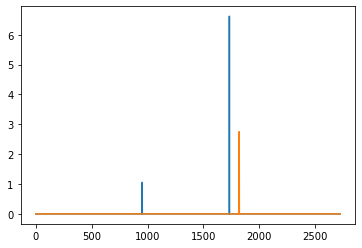

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(scores_sample[74])
plt.plot(scores_sample[118])

In [38]:
from __future__ import annotations
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.exceptions import ConvergenceWarning
from collections import Counter

from src.DAJIN2.core.clustering.merge_clusters import merge_clusters
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

###############################################################################
# Dimension reduction
###############################################################################


def reduce_dimension(scores_sample: list[list], scores_control_subset: list[list]) -> np.array:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores[0]))
    pca = PCA(n_components=n_components).fit(scores)
    return pca.transform(scores)


def optimize_labels(X: np.array, scores_sample: list[list], scores_control_subset: list[list]) -> list[int]:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores))
    labels_results = [1] * len(scores_sample)
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[: len(scores_sample)]
        labels_control = labels[len(scores_sample) :]
        labels_merged = merge_clusters(labels_control, labels_sample)
        labels_reorder = reorder_labels(labels_merged)
        # Reads < 1% in the control are considered clustering errors and are not counted
        count_control = Counter(labels_control)
        num_labels_control = sum(1 for reads in count_control.values() if reads/sum(count_control.values())*100 > 1)
        if num_labels_control > 1:
            return labels_results
        labels_results = labels_reorder
    return labels_results


###############################################################################
# main
###############################################################################


def return_labels(scores_sample: list[list], scores_control: list[list]) -> list[int]:
    np.random.seed(seed=1)
    X_control = reduce_dimension([], scores_control)
    labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
    label_most = Counter(labels).most_common()[0][0]
    scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
    X = reduce_dimension(scores_sample, scores_control_subset)
    labels = optimize_labels(X, scores_sample, scores_control_subset)
    return labels


In [39]:
np.random.seed(seed=1)
X_control = reduce_dimension([], scores_control)
labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
label_most = Counter(labels).most_common()[0][0]
scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
X = reduce_dimension(scores_sample, scores_control_subset)
labels = optimize_labels(X, scores_sample, scores_control_subset)


In [41]:
scores = scores_sample + scores_control_subset
n_components = min(20, len(scores))
labels_results = [1] * len(scores_sample)
for i in range(1, n_components):
    np.random.seed(seed=1)
    labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
    labels = labels.tolist()
    labels_sample = labels[: len(scores_sample)]
    labels_control = labels[len(scores_sample) :]
    labels_merged = merge_clusters(labels_control, labels_sample)
    labels_reorder = reorder_labels(labels_merged)
    print(i, Counter(labels_sample), Counter(labels_control)) # ! ========================
    # # Reads < 1% in the control are considered clustering errors and are not counted
    # count_control = Counter(labels_control)
    # num_labels_control = sum(1 for reads in count_control.values() if reads/sum(count_control.values())*100 > 1)
    # if num_labels_control > 1:
    #     return labels_results
    # labels_results = labels_reorder


1 Counter({0: 372}) Counter({0: 912})
2 Counter({1: 192, 0: 180}) Counter({0: 712, 1: 200})
3 Counter({1: 177, 0: 165, 2: 30}) Counter({0: 692, 1: 208, 2: 12})
4 Counter({1: 177, 0: 165, 3: 26, 2: 4}) Counter({0: 692, 1: 208, 3: 12})
5 Counter({0: 154, 1: 153, 4: 35, 3: 26, 2: 4}) Counter({0: 701, 1: 199, 3: 12})
6 Counter({0: 153, 1: 137, 4: 35, 3: 26, 5: 17, 2: 4}) Counter({0: 700, 1: 184, 5: 16, 3: 12})
7 Counter({0: 148, 1: 124, 4: 34, 3: 26, 6: 19, 5: 17, 2: 4}) Counter({0: 690, 1: 189, 5: 16, 3: 12, 6: 5})
8 Counter({1: 112, 0: 84, 6: 72, 4: 34, 2: 30, 3: 17, 5: 12, 7: 11}) Counter({1: 629, 0: 146, 6: 99, 3: 16, 2: 12, 7: 10})
9 Counter({1: 105, 0: 79, 6: 75, 4: 34, 2: 30, 3: 17, 5: 12, 7: 11, 8: 9}) Counter({1: 614, 0: 137, 6: 107, 8: 16, 3: 16, 2: 12, 7: 10})
10 Counter({1: 105, 0: 79, 6: 75, 4: 34, 2: 30, 9: 16, 5: 12, 7: 11, 8: 9, 3: 1}) Counter({1: 614, 0: 137, 6: 107, 8: 16, 9: 16, 2: 12, 7: 10})
11 Counter({1: 164, 0: 78, 4: 34, 2: 30, 9: 15, 5: 12, 6: 12, 7: 11, 8: 9, 10:

In [46]:
i = 2
np.random.seed(seed=1)
labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
labels = labels.tolist()
labels_sample = labels[: len(scores_sample)]
labels_control = labels[len(scores_sample) :]
labels_merged = merge_clusters(labels_control, labels_sample)
labels_reorder = reorder_labels(labels_merged)
print(i, Counter(labels_sample), Counter(labels_control)) # ! ========================


2 Counter({1: 192, 0: 180}) Counter({0: 712, 1: 200})


### まだ補正が足りない？？？
controlとright-loxpの２群に分かれてほしいのに…

In [61]:
print(labels_sample[:10])

[1, 1, 0, 1, 1, 1, 0, 1, 0, 1]


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

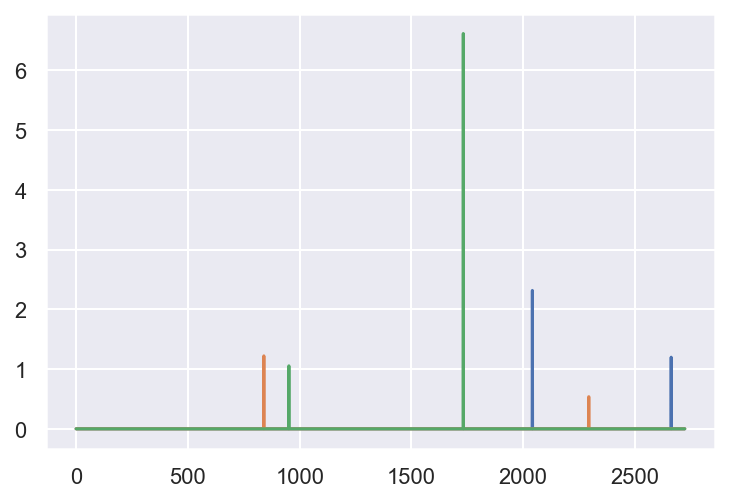

In [64]:
plt.plot(scores_sample[0])
plt.plot(scores_sample[2])
plt.plot(scores_sample[74]) # right-loxp

In [67]:
[i for i,s in enumerate(scores_sample[0]) if s > 1]

[2041, 2662]

In [69]:
print(mutation_score[2041])
print(mutation_score[2662])

{'=C,+I=G,=G': 2.317159868479517}
{'=T,+I=C,=T': 1.1996800853105838}


### 2041, 2662の補正はどうなっている？

In [75]:
from collections import defaultdict
from collections import Counter

count = defaultdict(int)
for cs in cssplits_control:
    count[cs[2041]] += 1
print("=====================")
print(f"control @ {2041}")
print(count)

count = defaultdict(int)
for cs in cssplits_sample:
    count[cs[2041]] += 1
print("=====================")
print(f"sample @ {2041}")
print(count)

control @ 2041
defaultdict(<class 'int'>, {'=G': 902, '+I=G': 14, 'N': 51, '+I*GT': 1})
sample @ 2041
defaultdict(<class 'int'>, {'+I=G': 14, '=G': 356, '+I*GA': 2})


In [76]:
print(count_5mer_sample[2041//5]["ins"])
print(count_5mer_control[2041//5]["ins"])
samp = [c / coverage_sample for c in count_5mer_sample[2041//5]["ins"]]
cont = [c / coverage_control for c in count_5mer_control[2041//5]["ins"]]
distance = 1 - cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
print(distance, pvalue)

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
0.9999999999999998 0.0


In [ ]:
print(count_5mer_sample[2662//5]["ins"])
print(count_5mer_control[2662//5]["ins"])
samp = [c / coverage_sample for c in count_5mer_sample[2662//5]["ins"]]
cont = [c / coverage_control for c in count_5mer_control[2662//5]["ins"]]
distance = 1 - cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
print(distance, pvalue)

[12, 11, 10, 6, 10]
[5, 20, 14, 19, 9]
0.8550649300550162 0.27782700006420435


# 結果


### extract_sequence_errors内のdistanceの閾値を0.9とした

- 改めてayabe-task1を実行
- distanceの閾値を下げたことによってマイナーな変異が補正される恐れがある
    - 1%の点変異が正しく抽出できているかを改めて検証する

### 一方で、補正をゆるくするのは根本的な解決にならない

+ 1%の点変異が抽出できていれば、0.95->0.9は良いと思う。0.95は厳しすぎる印象。
+ しかし、補正をゆるくする→新しい問題が勃発のいたちごっこ
    + 2662はdistanceが0.855なので補正されていない
    + 2041のinsertionがないのが謎
+ 根本の解決は、例えば`insersionのみのアレルを事前に生成する方針`がある

# 次回の課題

+ [x] ~~点変異、欠失、ノックインのデザインで動くかを確認する~~
+ [x] ~~Clusteringのときの警告メッセージは無害なので消去する~~
+ [ ] right_loxpがいまいちな理由を考察する
    +  ~~[x] Ayabe-task1のpreprocessにおいて、329と1280の補正がされていない理由を検討する~~
+ [ ] distanceの閾値を下げた状態で、1%点変異が検出できるか
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか

次回は
+ [ ] right_loxpがいまいちな理由を考察する
